## **Image classification using Siamese network with triplet loss**

**Few shot learning** is a technology capable of Few-shot learning refers to a variety of algorithms and techniques used to develop an AI model using a small amount of training data. Few-shot learning endeavours to let an AI model recognize and classify new data after being exposed to comparatively few training instances. Few-shot training stands in contrast to traditional methods of training machine learning models, where a large amount of training data is typically used. Few-shot learning is used primarily in computer vision tasks.  

#### **The Dataset**
We'll be using a custom made **Fruits dataset** reduced to 30 images per class for 6 classes.

- The dataset contains 6 different classes of fruits, with 30 images per class.
- The images are of size (128,128,3) and are encoded in RGB.
- Each image is named with a number, i.e 0.jpg, 1.jpg

## **Reading the Dataset**

We're reading the folders and splitting them into **train and test set** for training purposes.

In [145]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.5.0', '1.19.5')

## **Configure drive for google colab**

In [146]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
ROOT = '/content/drive/MyDrive/Colab Notebooks/dataset'

In [148]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    dim = (128, 128)
    # resize image
    resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

    return resized_image

## **Split the dataset into training and test set**

In [149]:
def get_folders_list():
  return os.listdir(ROOT)

In [150]:

def split_dataset(directory, split=0.9):
    folders = get_folders_list()
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.7)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)
print("\nTest List:", train_list)

Length of training list: 4
Length of testing list : 3

Test List: {'lemon': 30, 'apple': 30, 'mango': 30}

Test List: {'strawberry': 30, 'orange': 30, 'broccoli': 30, 'grape': 30}


### Creating Triplets

We use the train and test list to create triplets of **(anchor, postive, negative)** face data, where positive is the same person and negative is a different person than anchor.

In [151]:
def create_triplets(directory, folder_list, max_files=100):
    triplets = []
    folders = list(folder_list.keys())
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files - 1):
            for j in range(i + 1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")
                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder] - 1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets


In [152]:
def split_dataset_by_triplets(directory, split=0.7):
    folders = os.listdir(directory)
    
    folders_dict = { i : 30 for i in folders }

    all_triplets = create_triplets(ROOT, folders_dict)

    num_train = int(len(all_triplets) * split)

    random.shuffle(all_triplets)

    train_list, test_list = [], []

    # Creating Train-list
    for triplet in all_triplets[:num_train]:
        train_list.append(triplet)

    # Creating Test-list
    for triplet in all_triplets[num_train:]:
        test_list.append(triplet)

    return train_list, test_list

train_triplet_list, test_triplet_list = split_dataset_by_triplets(ROOT, split=0.7)
print(len(train_triplet_list), len(test_triplet_list))

2131 914


In [153]:
# train_triplet = create_triplets(ROOT, train_list)
# test_triplet  = create_triplets(ROOT, test_list)

train_triplet = train_triplet_list
test_triplet  = test_triplet_list

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))
# 
print("\nExamples of train triplets:")
for i in range(5):
    print(train_triplet[i])

print("\nExamples of test triplets:")
for i in range(5):
  print(test_triplet[i])

Number of training triplets: 2131
Number of testing triplets : 914

Examples of train triplets:
(('mango', '22.jpg'), ('mango', '24.jpg'), ('lemon', '27.jpg'))
(('broccoli', '16.jpg'), ('broccoli', '21.jpg'), ('lemon', '14.jpg'))
(('orange', '1.jpg'), ('orange', '6.jpg'), ('lemon', '27.jpg'))
(('grape', '17.jpg'), ('grape', '18.jpg'), ('orange', '28.jpg'))
(('lemon', '10.jpg'), ('lemon', '14.jpg'), ('strawberry', '3.jpg'))

Examples of test triplets:
(('broccoli', '5.jpg'), ('broccoli', '22.jpg'), ('orange', '5.jpg'))
(('orange', '12.jpg'), ('orange', '27.jpg'), ('grape', '20.jpg'))
(('apple', '1.jpg'), ('apple', '5.jpg'), ('orange', '2.jpg'))
(('orange', '8.jpg'), ('orange', '16.jpg'), ('apple', '16.jpg'))
(('strawberry', '11.jpg'), ('strawberry', '21.jpg'), ('lemon', '2.jpg'))


### Creating Batch-Generator

Creating a **Batch-Generator** that converts the triplets passed into batches of face-data and **preproccesses** it before returning the data into seperate lists.

**Parameters:**
- Batch_size: Batch_size of the data to return
- Preprocess: Whether to preprocess the data or not

In [154]:
def get_batch(triplet_list, batch_size=256, preprocess=True, return_true_class=False):
    batch_steps = len(triplet_list) // batch_size

    for i in range(batch_steps + 1):
        anchor = []
        positive = []
        negative = []
        true_class_values = []
        false_class_values = []

        j = i * batch_size
        while j < (i + 1) * batch_size and j < len(triplet_list):
            a, p, n = triplet_list[j]
            true_class_values.append(a[0])
            false_class_values.append(n[0])
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j += 1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        if return_true_class:
          yield ([anchor, positive, negative, true_class_values, false_class_values])
        else:
          yield ([anchor, positive, negative])

### Plotting the Data

Plotting the data generated from **get_batch()** to see the results

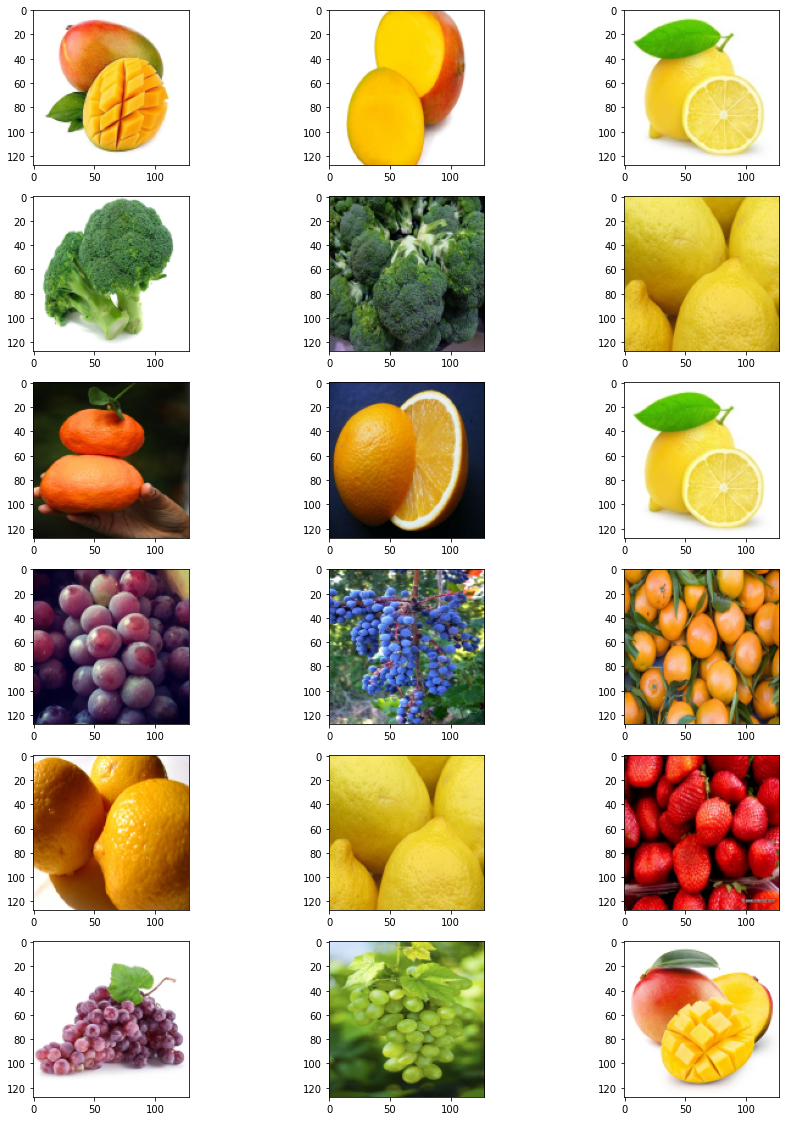

In [155]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## **Creating the Model**

Unlike a conventional CNN, the **Siamese Network** does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

![Siamese Network Image](https://miro.medium.com/max/2000/1*05hUCDHhnl4hdjqvdVTHtw.png)

In [156]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Encoder

The **Encoder** is responsible for converting the passed images into their feature vectors. We're using a pretrained model, **Xception model** which is based on **Inception_V3 model.** By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to **Fully Connected (Dense)** layers and the last layer normalises the data using **L2 Normalisation**. *(L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)*

In [157]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

### Siamese Network

We're creating a **Siamese Network** that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between **(anchor, positive)** and **(anchor, negative)** pairs.

We'll be defining a custom layer to compute the distance.

**Distance Formula**:

![image.png](attachment:5e83389c-697d-4b02-8b39-81f5eba0ba9e.png)

In [158]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          22043944    Anchor_Input[0][0]               
                                                                 Positive_Input[0][0

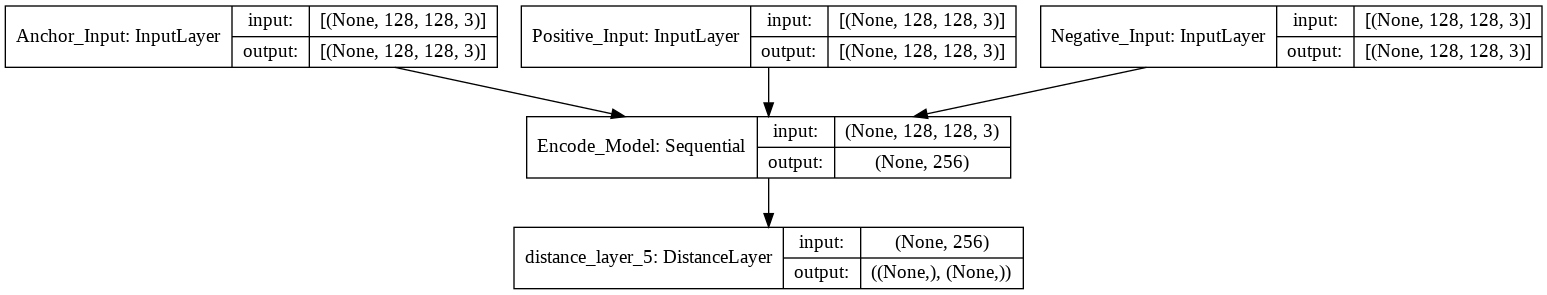

In [159]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

### Putting everything together

We now need to implement a model with custom training loop and loss function so we can compute the **triplet loss** using the three embeddings produced by the Siamese network.

We'll create a **Mean metric** instance to track the loss of the training process.

**Triplet Loss Function:**

<img src="https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png" alt="Loss Formula" width="400"/>

In [160]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [161]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

## **Training the Model**

We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.

### Test Function

**test_on_triplets()** function will be responsible for testing the model on test_triplets. It'll collect metrics **(accuracy, means, stds)** by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [162]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [164]:
save_all = False
epochs = 5
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs + 1):
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size, preprocess=True):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss) / len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time() - t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")

    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

    # Saving the model weights
    if save_all or accuracy >= max_acc:
        siamese_model.save_weights("/content/drive/MyDrive/Colab Notebooks/siamese_model")
        max_acc = accuracy
# Saving the model after all epochs run
siamese_model.save_weights("/content/drive/MyDrive/Colab Notebooks/siamese_model-final")


EPOCH: 1 	 (Epoch done in 752 sec)
Loss on train    = 0.36959
Accuracy on test = 0.94201

EPOCH: 2 	 (Epoch done in 735 sec)
Loss on train    = 0.12702
Accuracy on test = 0.97812

EPOCH: 3 	 (Epoch done in 725 sec)
Loss on train    = 0.05699
Accuracy on test = 0.99344

EPOCH: 4 	 (Epoch done in 732 sec)
Loss on train    = 0.01574
Accuracy on test = 0.99672

EPOCH: 5 	 (Epoch done in 736 sec)
Loss on train    = 0.00402
Accuracy on test = 1.00000


In [165]:
# def get_existing_siamese_model_triplet_loss():
#     siamese_network = get_siamese_network()
#     siamese_network.summary()

#     model = SiameseModel(siamese_network)
#     model.load_weights("/content/drive/MyDrive/Colab Notebooks/siamese_model-final")
#     return model

# siamese_model = get_existing_siamese_model_triplet_loss()

## **Evaluating the Model**


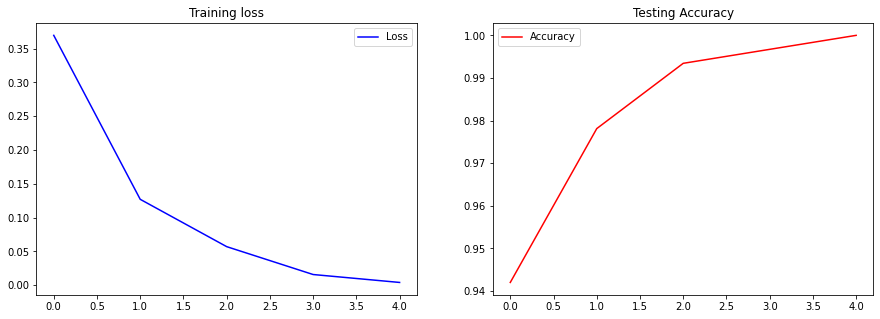

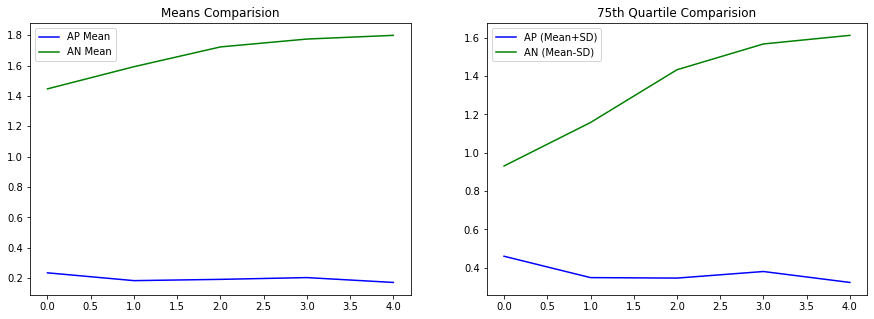

In [166]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

## **Using the Model**

Now that we've finished training our model, we need to **extract the encoder** so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for latter use.

In [167]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_44 (Batc (None, 512)               2048      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
lambda_8 (Lambda)            (None, 256)               0         
Total params: 22,043,944
Trainable params: 9,583,800
Non-trainable params: 12,460,144
__________________________________

### Classify Images

To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [168]:
def classify_images(face_list1, face_list2, threshold=1.25):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

In [169]:
def classify_images_2(a, p_n, a_class, p_n_class, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(a)
    tensor2 = encoder.predict(p_n)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)

    class_predictions = np.where(distance<=threshold, a_class, p_n_class)
    return list(class_predictions)

In [170]:
import pandas as pd

pred_pos_list = []
pred_neg_list = []
true_pos_list = []
true_neg_list = []

for data in get_batch(test_triplet, batch_size=256, return_true_class=True):
    a, p, n, pos_class_name, neg_class_name = data
    pos_classification = classify_images_2(a, p, pos_class_name, neg_class_name)
    neg_classification = classify_images_2(a, n, pos_class_name, neg_class_name)

    pred_pos_list += pos_classification
    pred_neg_list += neg_classification
    true_pos_list += pos_class_name
    true_neg_list += neg_class_name
    break


In [171]:
cf_matrix_true = confusion_matrix(true_pos_list, pred_pos_list)
cf_matrix_true = cf_matrix_true.astype('float') / cf_matrix_true.sum(axis=1)[:, np.newaxis]

print(cf_matrix_true)

cm_df_true = pd.DataFrame(cf_matrix_true)

[[1.         0.         0.         0.         0.         0.
  0.        ]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.02941176 0.         0.         0.97058824 0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


In [172]:
cf_matrix_false = confusion_matrix(true_neg_list, pred_neg_list)
cf_matrix_false = cf_matrix_false.astype('float') / cf_matrix_false.sum(axis=1)[:, np.newaxis]

print(cf_matrix_false)

cm_df_false = pd.DataFrame(cf_matrix_false)

[[1.         0.         0.         0.         0.         0.
  0.        ]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.95454545 0.         0.04545455
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.         0.02325581 0.97674419
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


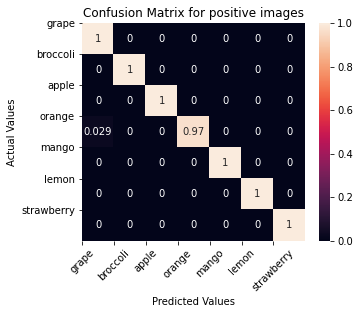

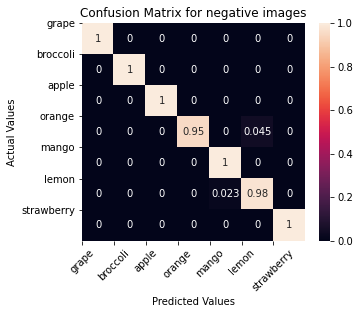

256


In [173]:
classes = get_folders_list()
# Plotting the positive confusion matrix
plt.figure(figsize=(5, 4))
cfm_plot_true = sns.heatmap(cm_df_true, annot=True)
plt.title('Confusion Matrix for positive images')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes, rotation=0)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
cfm_plot_true.figure.savefig("class_confusion_matrix_triplet_loss_true.png")

# Plotting the negative confusion matrix
plt.figure(figsize=(5, 4))
cfm_plot_true = sns.heatmap(cm_df_false, annot=True)
plt.title('Confusion Matrix for negative images')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes, rotation=0)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')


plt.show()
cfm_plot_true.figure.savefig("class_confusion_matrix_triplet_loss_false.png")
print(len(true_class_values))

## References

- FaceNet: A Unified Embedding for Face Recognition and Clustering: https://arxiv.org/abs/1503.03832
- Image similarity estimation using a Siamese Network with a triplet loss: https://keras.io/examples/vision/siamese_network/
- Celebrity Face Recognition: https://www.kaggle.com/ravehgillmore/celebrity-face-recognition/
- Face Recognition using Siamese Networks: https://medium.com/wicds/face-recognition-using-siamese-networks-84d6f2e54ea4
